In [156]:
import os
from mlcroissant import Dataset
import wfdb

from utils import read_event_file_as_list, yml_import, get_question_mapping
import logging
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report
from sklearn.preprocessing import MinMaxScaler

from sklearn import metrics
from sktime.classification.feature_based import Catch22Classifier
from sktime.datasets import load_basic_motions, load_italy_power_demand
from sktime.transformations.panel.catch22 import Catch22


# Data Import

In [157]:
#ANALYSIS_DATA_FILES = ["Kardio Events.txt", "Körperlage.txt"]
ANALYSIS_DATA_FILES = ["Schlafprofil.txt"]

#YAML_DATA_FILES = ['allgemeiner_schlaffragebogen_1.yml', 'allgemeiner_schlaffragebogen_1_2.yml']
YAML_DATA_FILES = []

In [158]:
def load_signals(base_path, sample_ids):
    psg_files = [os.path.join(base_path, sample_id, 'PSG', sample_id) for sample_id in sample_ids]

    signal_data = {}

    for psg_file in tqdm(psg_files, desc='Loading signals'):
        record = wfdb.rdrecord(psg_file)
        signal = np.transpose(record.p_signal)

        sort_index = np.argsort(record.sig_name)
        sorted_sig_name = np.array(record.sig_name)[sort_index]
        sorted_signal = signal[sort_index]

        signal_data[record.record_name] = {signal_name: signal_data for signal_name, signal_data in zip(sorted_sig_name, sorted_signal)}

    return signal_data

def load_analysis_and_yaml_files(base_path, sample_ids, analysis_data_files=ANALYSIS_DATA_FILES, yaml_data_files=YAML_DATA_FILES):

    analysis_data = {}
    yaml_data = {}
    logging.info(f'Loading {len(yaml_data_files)} yaml files and {len(analysis_data_files)} analysis files.')
    for sample_id in tqdm(sample_ids, desc='Loading analysis and yaml files'):
        analysis_data[sample_id] = {}
        yaml_data[sample_id] = {}

        for analysis_data_file in analysis_data_files:
            path = os.path.join(base_path, sample_id, 'PSG', 'Analysedaten', analysis_data_file)
            try:
                file_as_list, _, _ = read_event_file_as_list(path)
                analysis_data[sample_id][analysis_data_file] = file_as_list
            except FileNotFoundError:
                print(f"Warning: File {analysis_data_file} from sample {sample_id} not found. Leaving it empty.")
                analysis_data[sample_id][analysis_data_file] = None

        for yaml_data_file in yaml_data_files:
            path = os.path.join(base_path, sample_id, 'YAML', yaml_data_file)
            try:
                data = yml_import(path)
                yaml_data[sample_id][yaml_data_file] = data
            except FileNotFoundError:
                print(f"Warning: File {yaml_data_file} from sample {sample_id} not found. Leaving it empty.")
                yaml_data[sample_id][yaml_data_file] = None

    return analysis_data, yaml_data

def create_feature_vektor(viewed_features, block_size, add_metadata=True):
    df_main = pd.DataFrame()
    
    for patient, patient_data in signals.items():
        df_patient = pd.DataFrame()
        for feature in viewed_features:
            n_rows = len(patient_data[feature]) // block_size
            reshaped_array = patient_data[feature][:n_rows * block_size].reshape(n_rows, block_size)
            datapoint_column_names = [f"{feature}_{i + 1}" for i in range(block_size)]
    
            df = pd.DataFrame(reshaped_array, columns=datapoint_column_names)
            if add_metadata:
                df[f'{feature}_Min_Wert'] = df.min(axis=1)
                df[f'{feature}_Max_Wert'] = df.max(axis=1)
                df[f'{feature}_Mean_Wert'] = df.mean(axis=1)
                df[f'{feature}_Median'] = df.median(axis=1)
                df[f'{feature}_Std_Wert'] = df.std(axis=1)
                df[f'{feature}_Amplitude'] = df.max(axis=1) - df.min(axis=1)
    
            # Überprüfen, ob das Feature schon existiert
            if any(col.startswith(feature) for col in df_patient.columns):
                # Vertikales Kombinieren (neue Zeilen)
                df_patient = pd.concat([df_patient, df], axis=0, ignore_index=True)
            else:
                # Horizontales Kombinieren (neue Spalten)
                if df_patient.empty:
                    df_patient = df  # Erste Daten: einfach zuweisen
                else:
                    df_patient = pd.concat([df_patient.reset_index(drop=True),
                                            df.reset_index(drop=True)], axis=1)
    
        df_main = pd.concat([df_main, df_patient], axis=0, ignore_index=True)
    
    return df_main 

def get_labels():
    label_array=[]
    
    for patient, patient_labels in analysis_data.items():
        
        label_array = label_array + [x[1] for x in patient_labels["Schlafprofil.txt"]]
    
    return label_array



In [159]:
dataset = Dataset(jsonld="croissant.json")

base_path = dataset.metadata.url
print(f"Base path: {base_path}")
directory = os.getcwd()
base_path = os.path.join(directory, base_path)
    
sample_ids = os.listdir(base_path)
analysis_data_files = ANALYSIS_DATA_FILES
yaml_data_files = YAML_DATA_FILES

signals = load_signals(base_path, sample_ids)
logging.info(f'Loaded {len(signals)} signals.')

analysis_data, yaml_data = load_analysis_and_yaml_files(base_path, sample_ids, analysis_data_files, yaml_data_files)
logging.info(f'Loaded analysis data for {len(analysis_data)} samples.')
logging.info(f'Loaded YAML data for {len(yaml_data)} samples.')

# Optional: Get the question mapping
yaml_data_mapped = get_question_mapping(yaml_data)

  -  [Metadata(Comprehensive Polysomnography (CPS) Dataset: A Resource for Sleep-Related Arousal Research)] Property "https://schema.org/datePublished" is recommended, but does not exist.


Base path: ./data


Loading analysis and yaml files: 100%|██████████| 4/4 [00:00<00:00, 383.08it/s]


# Data Understanding

# Baseline Model

## Get Labels

In [160]:
df_label = pd.DataFrame()

df_label["Schlafprofil_label"] = get_labels()
df_label.head(5)


,Schlafprofil_label
0,A
1,Wach
2,Wach
3,Wach
4,Wach


## Data Formatting

In [161]:
features =["C3:A2"]

# Die Größe der Blöcke 
time_interval_block_size = 7680

df_main = create_feature_vektor(features, time_interval_block_size)

print("Anzahl an Datensätzen: " + str(len(df_main)))
df_main = pd.concat([df_main, df_label],axis=1)
print("Anzahl an Labels: " + str(len(df_label)))
print(df_main.shape)
df_main.iloc[:, list(range(5)) + list(range(-10, 0))].tail(10)

df_main.iloc[:, list(range(5)) + list(range(-10, 0))].head(10)

Anzahl an Datensätzen: 3777
Anzahl an Labels: 3782
(3782, 7687)


,C3:A2_1,C3:A2_2,C3:A2_3,C3:A2_4,C3:A2_5,C3:A2_7678,C3:A2_7679,C3:A2_7680,C3:A2_Min_Wert,C3:A2_Max_Wert,C3:A2_Mean_Wert,C3:A2_Median,C3:A2_Std_Wert,C3:A2_Amplitude,Schlafprofil_label
0,-1.220741e-08,3.295154e-06,-1.220741e-08,-1.907715e-06,-1.220741e-08,0.000012,1.131609e-05,0.000009,-0.000052,0.000053,-1.140730e-06,-9.348060e-07,0.000012,0.000104,A
1,7.092393e-06,4.898683e-06,3.332570e-06,2.481689e-06,2.014191e-06,-0.000007,-1.586939e-07,0.000006,-0.000052,0.000037,-4.594090e-07,-1.342795e-07,0.000012,0.000090,Wach
2,1.129168e-05,1.343372e-05,1.248798e-05,9.010619e-06,4.089418e-06,-0.000006,-1.077897e-05,-0.000015,-0.000040,0.000041,-4.702917e-07,-1.704216e-07,0.000011,0.000081,Wach
3,-1.722438e-05,-1.572971e-05,-1.075456e-05,-3.547912e-06,4.162661e-06,0.000010,1.241474e-05,0.000013,-0.000045,0.000041,-8.088137e-07,-8.911268e-07,0.000011,0.000086,Wach
4,1.119402e-05,8.275939e-06,4.919509e-06,2.256860e-06,1.110857e-06,0.000004,4.773022e-06,0.000007,-0.000044,0.000041,-5.273504e-07,-4.495154e-07,0.000011,0.000085,Wach
5,1.016861e-05,1.308086e-05,1.463645e-05,1.433101e-05,1.248798e-05,0.000001,2.380408e-06,0.000005,-0.000362,0.000148,-6.072375e-07,-5.834259e-07,0.000021,0.000510,Wach
6,8.239872e-06,1.244313e-05,1.649195e-05,1.932667e-05,2.005646e-05,-0.000011,-1.805447e-05,-0.000024,-0.000075,0.000071,-5.976810e-08,-7.550007e-07,0.000013,0.000146,Wach
7,-2.716106e-05,-2.756703e-05,-2.532998e-05,-2.099007e-05,-1.522240e-05,-0.000008,-6.213474e-06,-0.000004,-0.000047,0.000047,-8.401117e-07,-4.340459e-07,0.000012,0.000094,Wach
8,-1.794461e-06,-5.974539e-07,6.225682e-07,2.711921e-06,5.822843e-06,0.000003,4.357977e-06,0.000005,-0.000175,0.000116,-2.177925e-08,6.103624e-08,0.000016,0.000290,Wach
9,4.016175e-06,2.761075e-06,1.403830e-06,7.702396e-07,1.623560e-06,-0.000013,-1.690700e-05,-0.000017,-0.000090,0.000050,-1.542318e-06,-1.136346e-06,0.000012,0.000140,Wach


In [162]:
df_main = df_main.dropna()
print("Anzahl an Datenstätzen nach Reinigung: " + str(len(df_main)))
df_main.iloc[:, list(range(5)) + list(range(-10, 0))].tail(2)


Anzahl an Datenstätzen nach Reinigung: 3777


,C3:A2_1,C3:A2_2,C3:A2_3,C3:A2_4,C3:A2_5,C3:A2_7678,C3:A2_7679,C3:A2_7680,C3:A2_Min_Wert,C3:A2_Max_Wert,C3:A2_Mean_Wert,C3:A2_Median,C3:A2_Std_Wert,C3:A2_Amplitude,Schlafprofil_label
3775,-0.000028,-0.000028,-0.000030,-0.000032,-0.000034,0.000022,0.000029,0.000034,-0.000825,0.000771,2.341151e-06,0.000002,0.00011,0.001596,N2
3776,0.000031,0.000017,-0.000003,-0.000021,-0.000031,-0.000002,-0.000011,-0.000014,-0.000047,0.000039,5.198389e-07,0.000001,0.00001,0.000086,Wach


## Train-Test Split

In [163]:
X = df_main.drop(columns=['Schlafprofil_label'])  # Alle Spalten außer 'Label' sind Features
y = df_main['Schlafprofil_label'] 

data_train, data_test, label_train, label_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Building Model

In [164]:
from sklearn.ensemble import RandomForestClassifier

#clf = DecisionTreeClassifier()
clf = RandomForestClassifier()

clf.fit(data_train, label_train)


GradientBoostingClassifier()

## Evaluate Model

Genauigkeit des Modells: 0.56
Eindeutige Werte in label_test: ['A' 'N1' 'N2' 'N3' 'Rem' 'Wach']
Eindeutige Werte in data_pred: ['A' 'N1' 'N2' 'N3' 'Rem' 'Wach']
              precision    recall  f1-score   support

           A       0.00      0.00      0.00         1
          N1       0.10      0.01      0.02        84
          N2       0.53      0.82      0.64       294
          N3       0.82      0.46      0.59        79
         Rem       0.41      0.27      0.32        49
        Wach       0.60      0.52      0.56       249

    accuracy                           0.56       756
   macro avg       0.41      0.35      0.35       756
weighted avg       0.53      0.56      0.52       756



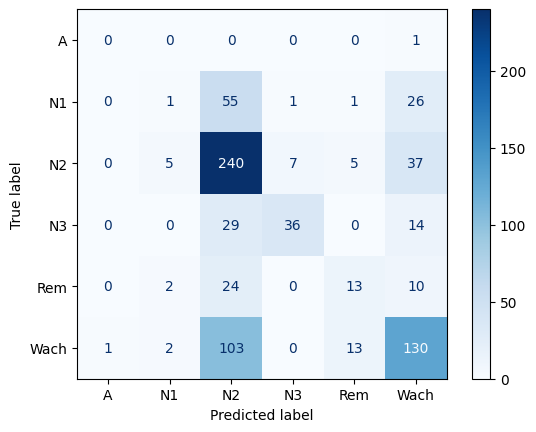

In [165]:
data_pred = clf.predict(data_test)
# Modell evaluieren
accuracy = accuracy_score(label_test, data_pred)
print(f"Genauigkeit des Modells: {accuracy:.2f}")

print("Eindeutige Werte in label_test:", np.unique(label_test))
print("Eindeutige Werte in data_pred:", np.unique(data_pred))

report = classification_report(label_test, data_pred)
print(report)

cm = confusion_matrix(label_test, data_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(label_test))
disp.plot(cmap=plt.cm.Blues, values_format='d')